In [1]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import copy
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score, fbeta_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import HistGradientBoostingClassifier

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Constants
lr = 5e-4
batch_size = 128
num_epochs = 75

# pd 
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Using device: cuda


In [2]:
def load_datasets(base_path="./"):
    
    files = {"train": "cs-training.csv"}
    dfs = {}
    
    for key, filename in files.items():
        print(f"Loading {filename}...")
        dfs[key] = pd.read_csv(base_path + filename, index_col=0)
        print(f"Loaded {filename} with {len(dfs[key].columns)} columns")
        
    return dfs

def dataset_summary(df, show_counts=True):
    
    total_rows = len(df)
    total_duplicates = df.duplicated().sum()
    
    summary = pd.DataFrame({
        "dtype": df.dtypes,
        "non_null_count": df.notna().sum(),
        "missing_count": df.isna().sum(),
        "missing_%": (df.isna().mean() * 100).round(2),
        "unique_count": df.nunique(),
        "duplicates_in_dataset": total_duplicates
    })
    
    print(f"Dataset shape: {df.shape}")
    if show_counts:
        print(f"Total rows: {total_rows}")
        print(f"Total duplicate rows: {total_duplicates}")
    summary = summary.sort_values(by="missing_%", ascending=False)
    
    return summary

def outlier_handling(df, target_col, threshold_high=99, threshold_low=1):
    
    df_copy = df.copy()
    
    numeric_cols = df_copy.select_dtypes(include=["float64", "int64", "float32"]).columns.tolist()
    df_copy[numeric_cols] = df_copy[numeric_cols].fillna(0)
    
    X = df_copy.drop(columns=[target_col])
    y = df_copy[target_col]

    hgb = HistGradientBoostingClassifier(
        max_iter=100,
        random_state=42,
        min_samples_leaf=20
    )
    hgb.fit(X, y)

    y_pred_proba = hgb.predict_proba(X)[:, 1]

    high_val = np.percentile(y_pred_proba, threshold_high)
    low_val = np.percentile(y_pred_proba, threshold_low)

    mask = (y_pred_proba < high_val) & (y_pred_proba > low_val)
    df_filtered = df_copy.loc[mask].reset_index(drop=True)

    print(f"Removed {len(df_copy) - len(df_filtered)} extreme rows according to model probabilities")
    print(df_filtered.describe())

    return df_filtered

def drop_target_and_ids(df):
    
    df_copy = df.copy()
    feature_cols_to_drop = ["SeriousDlqin2yrs"]
    target = df_copy["SeriousDlqin2yrs"]
    df_raw_features = df_copy.drop(columns=feature_cols_to_drop)
    
    print(f"Dropped target column: {feature_cols_to_drop}")
    
    return df_raw_features, target, feature_cols_to_drop

def engineer_features(df):
    """
    Create new engineered features for credit risk modeling.

    The goal is to extract behavioral, ratio-based, and interaction features
    from credit-related variables to better capture relationships
    linked to default risk or repayment probability.
    """
    
    df_engi = df.copy()

    # -------------------------------------------------------------------------
    # AGE CAPPING
    # Cap age at 100 to prevent outliers (e.g., data errors like 200+ years old)
    # and ensure all downstream ratios remain stable.
    # Keep both the capped 'age' and a duplicate 'age_capped' for reference.
    # -------------------------------------------------------------------------
    df_engi["age"] = np.minimum(df_engi["age"], 100)
    df_engi["age_capped"] = df_engi["age"]

    # -------------------------------------------------------------------------
    # DELINQUENCY-RELATED FEATURES
    # Capture overall and major delinquency behavior as indicators of risk.
    # -------------------------------------------------------------------------
    df_engi["TotalPastDue"] = (
        df_engi["NumberOfTime30-59DaysPastDueNotWorse"] +
        df_engi["NumberOfTimes90DaysLate"] +
        df_engi["NumberOfTime60-89DaysPastDueNotWorse"]
    )  # ➤ total count of all delinquent events
    df_engi["HasDelinquencyBinary"] = (df_engi["TotalPastDue"] > 0).astype(int)  # ➤ any delinquency
    df_engi["MajorDelinquencyBinary"] = (df_engi["NumberOfTimes90DaysLate"] > 0).astype(int)  # ➤ serious delinquency
    df_engi["HasMonthlyIncomeBinary"] = df_engi["MonthlyIncome"].notna().astype(int)  # ➤ income reporting flag

    # -------------------------------------------------------------------------
    # INCOME / DEBT RELATIONSHIPS
    # Key ratios that show how income interacts with debt exposure and credit usage.
    # -------------------------------------------------------------------------
    df_engi["MonthlyDebtAmount"] = df_engi["DebtRatio"] * df_engi["MonthlyIncome"]
    # ➤ estimated monthly debt payment amount

    df_engi["AvailableCreditRatio"] = (
        df_engi["NumberOfOpenCreditLinesAndLoans"] /
        df_engi["NumberRealEstateLoansOrLines"].replace(0, np.nan)
    )
    # ➤ ratio of open credit lines to real estate loans — proxy for portfolio mix

    df_engi["Log_MonthlyIncome"] = np.log1p(df_engi["MonthlyIncome"])
    # ➤ stabilizes skew in income distribution

    df_engi["UtilToAgeRatio"] = (
        df_engi["RevolvingUtilizationOfUnsecuredLines"] /
        df_engi["age"].replace(0, np.nan)
    )
    # ➤ normalizes utilization by age (younger borrowers tend to have higher utilization)

    # -------------------------------------------------------------------------
    # CREDIT MIX FEATURE
    # Encodes the composition of credit exposure to distinguish between borrowers
    # with real-estate vs consumer debt.
    # -------------------------------------------------------------------------
    def credit_mix(row):
        if row["NumberRealEstateLoansOrLines"] == 0 and row["NumberOfOpenCreditLinesAndLoans"] == 0:
            return "NoCredit"
        elif row["NumberRealEstateLoansOrLines"] > 0 and row["NumberOfOpenCreditLinesAndLoans"] == 0:
            return "RealEstateOnly"
        elif row["NumberRealEstateLoansOrLines"] == 0 and row["NumberOfOpenCreditLinesAndLoans"] > 0:
            return "OtherCreditOnly"
        else:
            return "MixedCredit"

    df_engi["CreditMix"] = df_engi.apply(credit_mix, axis=1)

    # -------------------------------------------------------------------------
    # HIGH UTILIZATION FLAG
    # Simple binary threshold — high utilization is a strong risk signal.
    # -------------------------------------------------------------------------
    threshold = 0.8
    df_engi["IsHighUtilizationBinary"] = (
        df_engi["RevolvingUtilizationOfUnsecuredLines"] > threshold
    ).astype(int)

    # -------------------------------------------------------------------------
    # RATIO AND INTERACTION FEATURES
    # Combine multiple behavioral and financial indicators to enrich the signal.
    # -------------------------------------------------------------------------
    df_engi["DebtRatioPerAge"] = (
        df_engi["DebtRatio"] / df_engi["age"].replace(0, np.nan)
    )  # ➤ younger borrowers with high debt ratio = higher risk

    df_engi["MonthlyDebtPerIncome"] = (
        df_engi["MonthlyDebtAmount"] / df_engi["MonthlyIncome"].replace(0, np.nan)
    )  # ➤ fraction of income spent on debt payments

    df_engi["PastDuePerCreditLine"] = (
        df_engi["TotalPastDue"] /
        (df_engi["NumberOfOpenCreditLinesAndLoans"] + df_engi["NumberRealEstateLoansOrLines"]).replace(0, np.nan)
    )  # ➤ delinquency rate per credit line

    df_engi["UtilTimesDebtRatio"] = (
        df_engi["RevolvingUtilizationOfUnsecuredLines"] * df_engi["DebtRatio"]
    )  # ➤ compound exposure to both utilization and indebtedness

    df_engi["AgeTimesIncome"] = df_engi["age"] * df_engi["MonthlyIncome"]
    # ➤ proxy for lifetime earning capacity

    # -------------------------------------------------------------------------
    # AGE BINNING
    # Convert age into ordered categorical buckets for non-linear patterns.
    # -------------------------------------------------------------------------
    df_engi["AgeBin"] = pd.cut(
        df_engi["age"],
        bins=[0, 25, 35, 45, 55, 65, 75, 85, 100],
        labels=[
            "Age_0_25", "Age_25_35", "Age_35_45", "Age_45_55",
            "Age_55_65", "Age_65_75", "Age_75_85", "Age_85_100"
        ],
        include_lowest=True
    )

    # -------------------------------------------------------------------------
    # ADVANCED INTERACTIONS
    # Multiply complementary variables to capture second-order relationships.
    # -------------------------------------------------------------------------
    df_engi["DebtTimesUtil"] = (
        df_engi["DebtRatio"] * df_engi["RevolvingUtilizationOfUnsecuredLines"]
    )  # ➤ joint measure of overall financial stress

    df_engi["IncomePerOpenCredit"] = (
        df_engi["MonthlyIncome"] /
        df_engi["NumberOfOpenCreditLinesAndLoans"].replace(0, np.nan)
    )  # ➤ average income per credit line — proxy for capacity

    df_engi["PastDuePerAge"] = (
        df_engi["TotalPastDue"] / df_engi["age"].replace(0, np.nan)
    )  # ➤ delinquency normalized by age

    df_engi["DebtPerCreditTimesAge"] = (
        df_engi["DebtRatioPerAge"] * df_engi["NumberOfOpenCreditLinesAndLoans"]
    )  # ➤ how exposure scales with both debt ratio and age

    # -------------------------------------------------------------------------
    print("Engineered features")
    
    return df_engi

def drop_high_missing_cols(df, threshold=0.3):
    
    missing_frac = df.isna().mean()
    hm_cols_to_drop = missing_frac[missing_frac > threshold].index.tolist()
    
    if hm_cols_to_drop:
        df_drop = df.drop(columns=hm_cols_to_drop)
        print(f"Dropped {len(hm_cols_to_drop)} columns with missing >{threshold*100:.0f}%")
        print(f"Columns dropped: {hm_cols_to_drop}")
    else:
        df_drop = df.copy()
        print("No columns dropped for missing threshold")
        
    return df_drop, hm_cols_to_drop

def drop_high_card_cols(df, threshold=50):
    
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    hc_cols_to_drop = [col for col in cat_cols if df[col].nunique() > threshold]
    
    if hc_cols_to_drop:
        df_high = df.drop(columns=hc_cols_to_drop, errors='ignore')
        print(f"Dropped {len(hc_cols_to_drop)} high-cardinality columns (> {threshold} unique)")
        print(f"Columns dropped: {hc_cols_to_drop}")
    else:
        df_high = df.copy()
        print("No high-cardinality columns dropped")
        
    return df_high, hc_cols_to_drop

def drop_correlated(df, threshold=0.95):
    
    df_temp = df.copy()
    
    cat_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in cat_cols:
        df_temp[col] = df_temp[col].astype('category').cat.codes

    corr_matrix = df_temp.corr().abs()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, linewidths=0.5)
    plt.title("Feature Correlation Matrix (Before Dropping)")
    plt.show()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    corr_cols_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    if corr_cols_to_drop:
        df_corr = df.drop(columns=corr_cols_to_drop)
        print(f"Dropped {len(corr_cols_to_drop)} highly correlated columns (>|{threshold}|).")
        print(f"Columns dropped: {corr_cols_to_drop}")
    else:
        df_corr = df.copy()
        print("No highly correlated features dropped.")

    return df_corr, corr_cols_to_drop

def collapse_rare_categories(df, threshold=0.005):
    
    df_copy = df.copy()
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    
    rare_maps = {}
    for col in cat_cols:
        freqs = df_copy[col].value_counts(normalize=True)
        rare_cats = freqs[freqs < threshold].index
        if len(rare_cats) > 0:
            df_copy[col] = df_copy[col].astype('object').replace(rare_cats, 'Other')
            rare_maps[col] = set(rare_cats)
            print(f"Collapsed {len(rare_cats)} rare categories in column '{col}'")
            
            print(f"Categories dropped: {list(rare_cats)}")
    if not rare_maps:
        print("No rare categories collapsed")
        rare_maps = None
        
    return df_copy, rare_maps

def impute_and_scale(df, threshold=1.0):
    
    df_copy = df.copy()
    numeric_cols = df_copy.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    num_imputer = None
    cat_imputer = None
    robust_scaler = None
    std_scaler = None
    
    if numeric_cols:
        df_copy[numeric_cols] = df_copy[numeric_cols].replace([np.inf, -np.inf], np.nan)
        num_imputer = SimpleImputer(strategy='median')
        df_copy[numeric_cols] = num_imputer.fit_transform(df_copy[numeric_cols])
    if cat_cols:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_copy[cat_cols] = cat_imputer.fit_transform(df_copy[cat_cols])
    if numeric_cols:
        skewness = pd.DataFrame(df_copy[numeric_cols]).skew().sort_values(ascending=False)
        skewed_cols = skewness[abs(skewness) > threshold].index.tolist()
        if skewed_cols:
            robust_scaler = RobustScaler()
            df_copy[skewed_cols] = robust_scaler.fit_transform(df_copy[skewed_cols]).astype(np.float32)
        normal_cols = [c for c in numeric_cols if c not in skewed_cols]
        if normal_cols:
            std_scaler = StandardScaler()
            df_copy[normal_cols] = std_scaler.fit_transform(df_copy[normal_cols]).astype(np.float32)
    df_processed = df_copy.copy()
    
    print("Imputed and scaled features")
    
    return df_processed, num_imputer, cat_imputer, robust_scaler, std_scaler

def select_features_xgb(df, target, top_n=20, threshold=None, random_state=42):
 
    df_temp = df.copy()
    cat_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in cat_cols:
        df_temp[col] = df_temp[col].astype('category').cat.codes
        
    X_train, X_val, y_train, y_val = train_test_split(
        df_temp, target, test_size=0.2, random_state=random_state, stratify=target
    )
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    neg_count = sum(y_train == 0)
    pos_count = sum(y_train == 1)
    scale_pos_weight = neg_count / pos_count
    
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "eta": 0.03,
        "max_depth": 4,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "gamma": 0.1,
        "lambda": 1.5,
        "alpha": 0.3,
        "seed": random_state,
        "scale_pos_weight": scale_pos_weight
    }   
    evals = [(dtrain, "train"), (dval, "validation")]
    
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    importance_dict = model.get_score(importance_type='gain')
    importances = pd.Series(importance_dict).sort_values(ascending=False)
    if threshold is None:
        threshold_value = importances.quantile(0.75)
        selected_features = importances[importances >= threshold_value].index.tolist()
    else:
        selected_features = importances[importances >= threshold].index.tolist()
    dropped_features = [col for col in df.columns if col not in selected_features]
    
    if selected_features:
        df_selected = df[selected_features].copy()
        print(f"Dropped {len(dropped_features)} features")
        print(f"Columns dropped: {dropped_features}")
    else:
        df_selected = df.copy()
        print("No features selected/dropped")
        
    top_features = importances.head(top_n)
    plt.figure(figsize=(10, 6))
    plt.barh(top_features.index[::-1], top_features.values[::-1], color='skyblue')
    plt.xlabel("Feature Importance (gain)")
    plt.title(f"Top {top_n} XGBoost Feature Importances")
    plt.tight_layout()
    plt.show()
    
    return df_selected, selected_features

def transform_val_test(df, cols_to_drop, selected_features, rare_maps, num_imputer, cat_imputer, robust_scaler, std_scaler):
    
    df_copy = df.copy()
    
    if cols_to_drop:
        df_copy = df_copy.drop(columns=cols_to_drop, errors='ignore')
    
    if rare_maps:
        for col, rare_cats in rare_maps.items():
            if col in df_copy.columns:
                df_copy[col] = df_copy[col].apply(lambda x: x if x not in rare_cats else 'Other')
    
    numeric_cols = df_copy.select_dtypes(include=['number']).columns.tolist()
    
    if numeric_cols and num_imputer:
        df_copy[numeric_cols] = df_copy[numeric_cols].replace([np.inf, -np.inf], np.nan)
        df_copy[numeric_cols] = num_imputer.transform(df_copy[numeric_cols])
    
    if robust_scaler:
        skewed_cols = robust_scaler.feature_names_in_
        df_copy[skewed_cols] = robust_scaler.transform(df_copy[skewed_cols]).astype(np.float32)
    
    if std_scaler:
        normal_cols = [c for c in numeric_cols if robust_scaler is None or c not in robust_scaler.feature_names_in_]
        if normal_cols:
            df_copy[normal_cols] = std_scaler.transform(df_copy[normal_cols]).astype(np.float32)
    
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    if cat_cols and cat_imputer:
        df_copy[cat_cols] = cat_imputer.transform(df_copy[cat_cols])
    
    if selected_features:
        df_copy = df_copy.reindex(columns=selected_features, fill_value=0)
    
    return df_copy

def check_and_drop_duplicates(df, target=None, drop_target_na=False, show_info=True):
    
    df_cleaned = df.copy()
    target_cleaned = None
    
    total_duplicates = df_cleaned.duplicated().sum()
    if total_duplicates > 0:
        df_cleaned = df_cleaned.drop_duplicates(keep='first')
        if show_info:
            print(f"Dropped {total_duplicates} duplicate rows. Remaining: {len(df_cleaned)}")
    
    if target is not None:
        target_cleaned = pd.Series(target).reindex(df_cleaned.index)
        if drop_target_na:
            mask = target_cleaned.notna()
            dropped = len(target_cleaned) - mask.sum()
            if dropped > 0 and show_info:
                print(f"Dropped {dropped} rows with missing target values")
            df_cleaned = df_cleaned.loc[mask].reset_index(drop=True)
            target_cleaned = target_cleaned.loc[mask].reset_index(drop=True)
        else:
            target_cleaned = target_cleaned.reset_index(drop=True)
        return df_cleaned, target_cleaned
    else:
        return df_cleaned

In [3]:
# Load datasets
dfs = load_datasets()
df_train = dfs["train"]

Loading cs-training.csv...
Loaded cs-training.csv with 11 columns


In [4]:
#summary
print(dataset_summary(df_train))
print(df_train.head(5))

Dataset shape: (150000, 11)
Total rows: 150000
Total duplicate rows: 609
                                        dtype  non_null_count  missing_count  \
MonthlyIncome                         float64          120269          29731   
NumberOfDependents                    float64          146076           3924   
SeriousDlqin2yrs                        int64          150000              0   
age                                     int64          150000              0   
RevolvingUtilizationOfUnsecuredLines  float64          150000              0   
DebtRatio                             float64          150000              0   
NumberOfTime30-59DaysPastDueNotWorse    int64          150000              0   
NumberOfOpenCreditLinesAndLoans         int64          150000              0   
NumberOfTimes90DaysLate                 int64          150000              0   
NumberRealEstateLoansOrLines            int64          150000              0   
NumberOfTime60-89DaysPastDueNotWorse    int64  

In [5]:
# Outlier Handling
df_train = df_train[df_train['age'] > 0].reset_index(drop=True)
df_filtered = outlier_handling(df_train, target_col="SeriousDlqin2yrs", threshold_high=99.975, threshold_low=0.025)

Removed 91 extreme rows according to model probabilities
       SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines            age  \
count     149908.000000                         149908.000000  149908.000000   
mean           0.066634                              6.051849      52.285702   
std            0.249388                            249.831960      14.760697   
min            0.000000                              0.000000      21.000000   
25%            0.000000                              0.029924      41.000000   
50%            0.000000                              0.154247      52.000000   
75%            0.000000                              0.558875      63.000000   
max            1.000000                          50708.000000     109.000000   

       NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  MonthlyIncome  \
count                         149908.000000  149908.000000   1.499080e+05   
mean                               0.420611     353.118499   5.35032

In [6]:
# Select targets
df_features, target, feature_cols_to_drop = drop_target_and_ids(df_filtered)
print(target.value_counts())

Dropped target column: ['SeriousDlqin2yrs']
SeriousDlqin2yrs
0    139919
1      9989
Name: count, dtype: int64


In [7]:
# Split train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df_features, target, test_size=0.2, stratify=target, random_state=42
)

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

In [8]:
# Engineer_features
df_engi = engineer_features(X_train)

Engineered features


In [9]:
# Drop columns with missing
df_drop, hm_cols_to_drop = drop_high_missing_cols(df_engi, threshold=1)

No columns dropped for missing threshold


In [10]:
# Drop high card
df_high, hc_cols_to_drop = drop_high_card_cols(df_drop, threshold=50)

No high-cardinality columns dropped


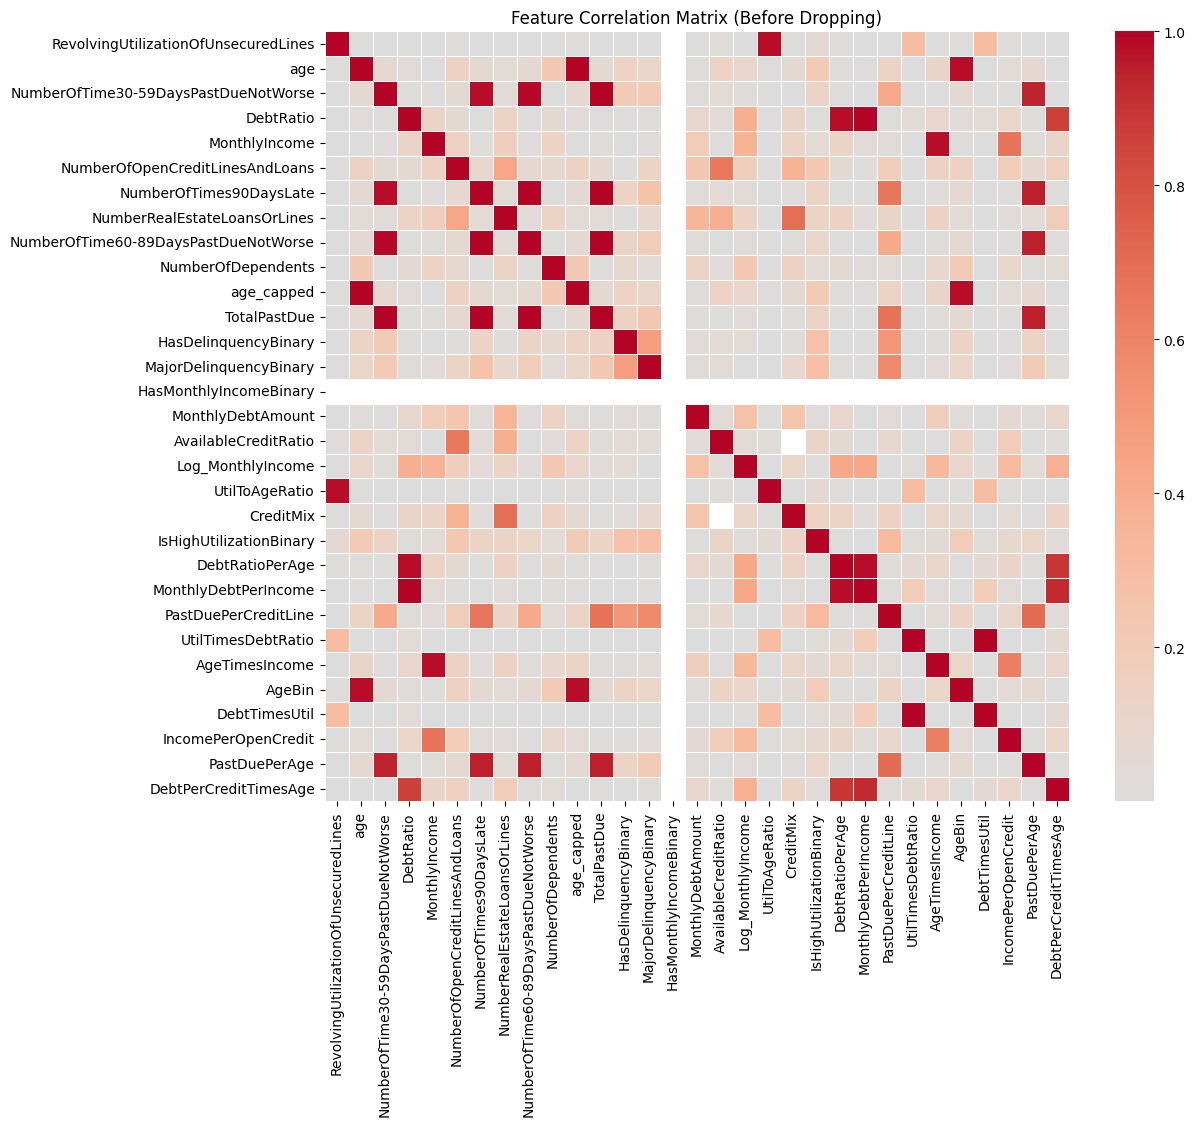

No highly correlated features dropped.


In [11]:
# Drop correlated features
df_corr, corr_cols_to_drop = drop_correlated(df_high, threshold=9999)

In [12]:
# Collapse rare categories
df_collapsed, rare_maps = collapse_rare_categories(df_corr, threshold=0.01)

No rare categories collapsed


In [13]:
# Impute and scale
df_processed, num_imputer, cat_imputer, robust_scaler, std_scaler  = impute_and_scale(df_collapsed , threshold=1.0)

Imputed and scaled features


Dropped 7 features
Columns dropped: ['DebtRatio', 'MonthlyIncome', 'NumberOfDependents', 'HasMonthlyIncomeBinary', 'CreditMix', 'UtilTimesDebtRatio', 'DebtTimesUtil']


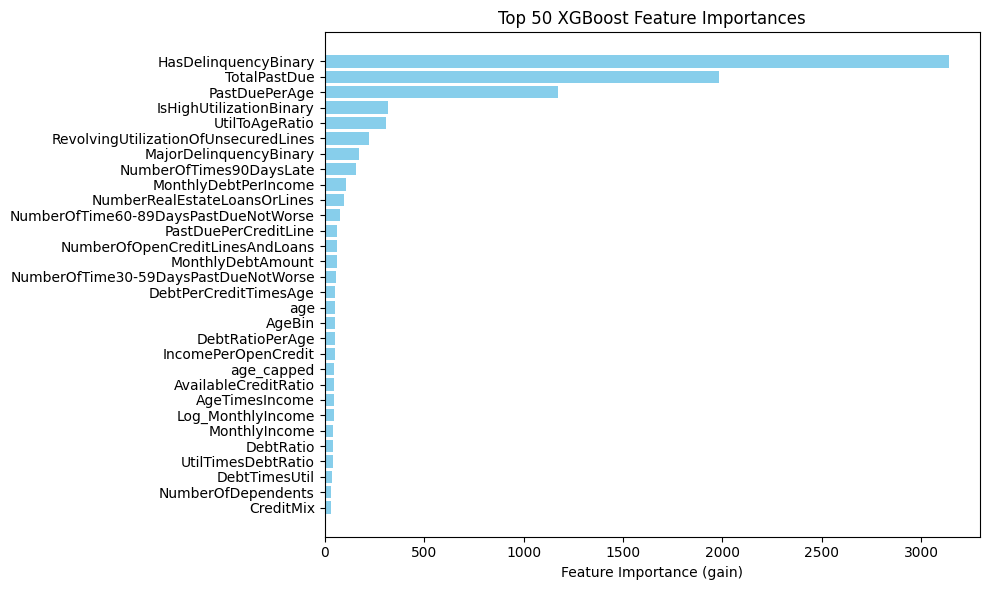

In [14]:
# Feature selection
df_selected, selected_features = select_features_xgb(df_processed, y_train, threshold=45, top_n=50)

In [15]:
# Process
all_cols_to_drop = feature_cols_to_drop + hm_cols_to_drop + corr_cols_to_drop + hc_cols_to_drop

X_val = engineer_features(X_val)
X_val = transform_val_test(X_val, all_cols_to_drop, selected_features, rare_maps, num_imputer, cat_imputer, robust_scaler, std_scaler)

X_test = engineer_features(X_test)
X_test = transform_val_test(X_test, all_cols_to_drop, selected_features, rare_maps, num_imputer, cat_imputer, robust_scaler, std_scaler)
X_train = df_selected.copy()

Engineered features
Engineered features


In [16]:
# Drop duplicates
X_train, y_train = check_and_drop_duplicates(X_train, y_train)

Dropped 464 duplicate rows. Remaining: 95476


In [17]:
#summary
print(dataset_summary(X_train))

Dataset shape: (95476, 24)
Total rows: 95476
Total duplicate rows: 0
                                        dtype  non_null_count  missing_count  \
HasDelinquencyBinary                  float32           95476              0   
TotalPastDue                          float32           95476              0   
PastDuePerAge                         float32           95476              0   
IsHighUtilizationBinary               float32           95476              0   
UtilToAgeRatio                        float32           95476              0   
RevolvingUtilizationOfUnsecuredLines  float32           95476              0   
MajorDelinquencyBinary                float32           95476              0   
NumberOfTimes90DaysLate               float32           95476              0   
MonthlyDebtPerIncome                  float32           95476              0   
NumberRealEstateLoansOrLines          float32           95476              0   
NumberOfTime60-89DaysPastDueNotWorse  float32      

In [18]:
# Encode
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

cat_maps = {
    col: {cat: idx for idx, cat in enumerate(X_train[col].astype(str).unique())}
    for col in cat_cols
}

for col in cat_cols:
    X_train[col] = X_train[col].astype(str).map(cat_maps[col]).fillna(0).astype(int)
    X_val[col] = X_val[col].astype(str).map(cat_maps[col]).fillna(0).astype(int)
    X_test[col] = X_test[col].astype(str).map(cat_maps[col]).fillna(0).astype(int)

num_cols = [col for col in X_train.columns if col not in cat_cols]

X_train_num = X_train[num_cols].astype('float32').values
X_val_num = X_val[num_cols].astype('float32').values
X_test_num = X_test[num_cols].astype('float32').values

X_train_cat = X_train[cat_cols].astype('int64').values
X_val_cat = X_val[cat_cols].astype('int64').values
X_test_cat = X_test[cat_cols].astype('int64').values

In [19]:
# Convert to tensors
X_train_num_tensor = torch.tensor(X_train_num)
X_val_num_tensor = torch.tensor(X_val_num)
X_test_num_tensor = torch.tensor(X_test_num)

X_train_cat_tensor = torch.tensor(X_train_cat)
X_val_cat_tensor = torch.tensor(X_val_cat)
X_test_cat_tensor = torch.tensor(X_test_cat)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
weights_tensor = torch.tensor([class_weight_dict[int(c)] for c in y_train], dtype=torch.float32)

print("Numeric input shape:", X_train_num_tensor.shape)
print("Categorical input shape:", X_train_cat_tensor.shape)
print("Class weights:", class_weight_dict)

Numeric input shape: torch.Size([95476, 23])
Categorical input shape: torch.Size([95476, 1])
Class weights: {np.int64(0): np.float64(0.5357259087185358), np.int64(1): np.float64(7.497722632322915)}


In [20]:
# Datasets
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, x_num, x_cat, y):
        self.x_num = x_num
        self.x_cat = x_cat
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_num[idx], self.x_cat[idx], self.y[idx]

train_ds = TabularDataset(X_train_num_tensor, X_train_cat_tensor, y_train_tensor)
val_ds = TabularDataset(X_val_num_tensor, X_val_cat_tensor, y_val_tensor)
test_ds = TabularDataset(X_test_num_tensor, X_test_cat_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 95476, Val: 23986, Test: 29982


In [21]:
# Model
class NN(nn.Module):
    def __init__(self, num_numeric, cat_dims, emb_dims):
        super().__init__()

        self.emb_layers = nn.ModuleList([
            nn.Embedding(cat_dim, emb_dim)
            for cat_dim, emb_dim in zip(cat_dims, emb_dims)
        ])
        self.emb_dropout = nn.Dropout(0.3)

        self.bn_num = nn.BatchNorm1d(num_numeric)

        total_emb_dim = sum(emb_dims)
        self.input_dim = num_numeric + total_emb_dim

        self.fc1 = nn.Linear(self.input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)

        self.skip_proj_main = nn.Linear(self.input_dim, 128)

        self.cat_skip = nn.Sequential(
            nn.Linear(total_emb_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.out = nn.Linear(128, 1)

        self.act = nn.ReLU()
        self.drop = nn.Dropout(0.5)

    def forward(self, x_num, x_cat):
        emb_outs = [emb(x_cat[:, i]) for i, emb in enumerate(self.emb_layers)]
        x_cat_emb = torch.cat(emb_outs, dim=1)
        x_cat_emb = self.emb_dropout(x_cat_emb)

        x_num = self.bn_num(x_num)

        x = torch.cat([x_num, x_cat_emb], dim=1)

        x1 = self.act(self.bn1(self.fc1(x)))
        x1 = self.drop(x1)
        x2 = self.act(self.bn2(self.fc2(x1)))
        x2 = self.drop(x2)

        x_main_skip = self.skip_proj_main(x)
        x_cat_skip = self.cat_skip(x_cat_emb)

        x2 = x2 + x_main_skip + x_cat_skip

        out = self.out(x2)
        return out.squeeze(1)

cat_dims = [len(cat_maps[col]) for col in cat_cols]
emb_dims = [min(50, (cat_dim + 1) // 2) for cat_dim in cat_dims]

model = NN(X_train_num.shape[1], cat_dims, emb_dims).to(device)
print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters()))

NN(
  (emb_layers): ModuleList(
    (0): Embedding(8, 4)
  )
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (bn_num): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=27, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (skip_proj_main): Linear(in_features=27, out_features=128, bias=True)
  (cat_skip): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
  (act): ReLU()
  (drop): Dropout(p=0.5, inplace=False)
)
Total parameters: 45519


In [22]:
class FocalLoss(nn.Module): 
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):

        bce_loss = F.binary_cross_entropy_with_logits(
            logits, targets, reduction='none',
            pos_weight=torch.tensor(self.pos_weight, device=logits.device) if self.pos_weight else None
        )

        p_t = torch.exp(-bce_loss)
        
        focal_loss = (self.alpha * (1 - p_t) ** self.gamma * bce_loss)
        return focal_loss.mean()

alpha = class_weights[1] / (class_weights[0] + class_weights[1])
loss_fn = FocalLoss(alpha=alpha, gamma=2)

In [23]:
num_runs = 3
overall_best_val_auc = 0.0
overall_best_model_state = None

for run in range(num_runs):
    print(f"\n=== Run {run + 1}/{num_runs} ===")

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.5
    )

    best_val_auc_this_run = 0.0
    best_model_state_this_run = None
    patience_counter = 0
    max_patience = 17

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        train_logits, train_labels = [], []

        for x_num, x_cat, yb in train_loader:
            x_num, x_cat, yb = x_num.to(device), x_cat.to(device), yb.to(device).float()
        
            optimizer.zero_grad()
            logits = model(x_num, x_cat)  
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * x_num.size(0)
            train_logits.append(logits.detach().cpu())
            train_labels.append(yb.cpu())

        train_loss = total_train_loss / len(train_loader.dataset)
        train_logits = torch.cat(train_logits)
        train_labels = torch.cat(train_labels)
        train_probs = torch.sigmoid(train_logits).numpy()
        train_auc = roc_auc_score(train_labels.numpy(), train_probs)

        model.eval()
        total_val_loss = 0.0
        val_logits, val_labels = [], []

        with torch.no_grad():
            for x_num, x_cat, yb in val_loader:
                x_num, x_cat, yb = x_num.to(device), x_cat.to(device), yb.to(device).float()
                logits = model(x_num, x_cat)
            
                loss = loss_fn(logits, yb)
                total_val_loss += loss.item() * x_num.size(0)
                val_logits.append(logits.cpu())
                val_labels.append(yb.cpu())

        val_loss = total_val_loss / len(val_loader.dataset)
        val_logits = torch.cat(val_logits)
        val_labels = torch.cat(val_labels)
        val_probs = torch.sigmoid(val_logits).numpy()
        val_auc = roc_auc_score(val_labels.numpy(), val_probs)

        if val_auc > best_val_auc_this_run:
            best_val_auc_this_run = val_auc
            best_model_state_this_run = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        scheduler.step(val_auc)

        print(f"Epoch {epoch + 1}/{num_epochs} | "
              f"Train loss: {train_loss:.6f} | Train AUC: {train_auc:.4f} | "
              f"Val loss: {val_loss:.6f} | Val AUC: {val_auc:.4f}")

    print(f"Run {run + 1} best Val AUC: {best_val_auc_this_run:.4f}")

    if best_val_auc_this_run > overall_best_val_auc:
        overall_best_val_auc = best_val_auc_this_run
        overall_best_model_state = copy.deepcopy(best_model_state_this_run)

model.load_state_dict(overall_best_model_state)
print(f"\nBest model across all runs restored (Val AUC = {overall_best_val_auc:.4f})")


=== Run 1/3 ===
Epoch 1/75 | Train loss: 0.054232 | Train AUC: 0.8050 | Val loss: 0.052982 | Val AUC: 0.8432
Epoch 2/75 | Train loss: 0.048263 | Train AUC: 0.8420 | Val loss: 0.051026 | Val AUC: 0.8434
Epoch 3/75 | Train loss: 0.047677 | Train AUC: 0.8467 | Val loss: 0.052283 | Val AUC: 0.8404
Epoch 4/75 | Train loss: 0.047480 | Train AUC: 0.8487 | Val loss: 0.050964 | Val AUC: 0.8443
Epoch 5/75 | Train loss: 0.047410 | Train AUC: 0.8494 | Val loss: 0.052064 | Val AUC: 0.8459
Epoch 6/75 | Train loss: 0.047325 | Train AUC: 0.8498 | Val loss: 0.054821 | Val AUC: 0.8477
Epoch 7/75 | Train loss: 0.047199 | Train AUC: 0.8513 | Val loss: 0.052616 | Val AUC: 0.8399
Epoch 8/75 | Train loss: 0.047097 | Train AUC: 0.8517 | Val loss: 0.054915 | Val AUC: 0.8472
Epoch 9/75 | Train loss: 0.046943 | Train AUC: 0.8532 | Val loss: 0.052246 | Val AUC: 0.8478
Epoch 10/75 | Train loss: 0.046887 | Train AUC: 0.8535 | Val loss: 0.050529 | Val AUC: 0.8445
Epoch 11/75 | Train loss: 0.047031 | Train AUC: 0.85

Best threshold for F1: 0.30554828
              precision    recall  f1-score   support

      Repaid       0.97      0.87      0.92     27984
   Defaulted       0.26      0.68      0.38      1998

    accuracy                           0.85     29982
   macro avg       0.62      0.77      0.65     29982
weighted avg       0.93      0.85      0.88     29982

Accuracy: 85.32%
ROC AUC: 0.849
TP=1351, FP=3755, TN=24229, FN=647
Accuracy for class 'Repaid': 86.58%
Accuracy for class 'Defaulted': 67.62%


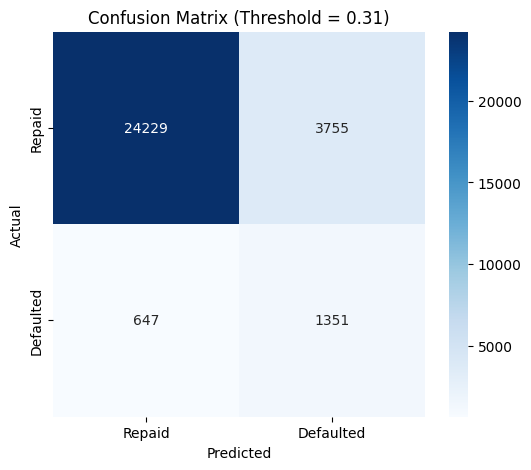

In [24]:
# Evaluation
model.eval()
y_val_probs = []

with torch.no_grad():
    for x_num, x_cat, yb in val_loader:
        x_num, x_cat = x_num.to(device), x_cat.to(device)
        outputs = model(x_num, x_cat)
        probs = torch.sigmoid(outputs)
        y_val_probs.extend(probs.cpu().numpy())

y_val_probs = np.array(y_val_probs)

# Target defaults
prec, rec, thresholds = precision_recall_curve(y_val, y_val_probs)
f_beta_scores = [fbeta_score(y_val, (y_val_probs > t).astype(int), beta=2) for t in thresholds]
best_thresh = thresholds[np.argmax(f_beta_scores)]

y_test_probs = []
with torch.no_grad():
    for x_num, x_cat, _ in test_loader:
        x_num, x_cat = x_num.to(device), x_cat.to(device)
        outputs = model(x_num, x_cat)
        probs = torch.sigmoid(outputs)
        y_test_probs.extend(probs.cpu().numpy())

y_test_probs = np.array(y_test_probs)
y_test_pred_opt = (y_test_probs > best_thresh).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_test_pred_opt, target_names=target_names)
acc = accuracy_score(y_test, y_test_pred_opt)
roc_auc = roc_auc_score(y_test, y_test_probs)
cm = confusion_matrix(y_test, y_test_pred_opt)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("Best threshold for F1:", best_thresh)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh:.2f})")
plt.show()

In [29]:
# Data sets
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test) 

In [30]:
# Model
neg_count = sum(y_train == 0)
pos_count = sum(y_train == 1)
scale_pos_weight = neg_count / pos_count
print("scale_pos_weight:", scale_pos_weight)

params = {
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "auc"], 
    "eta": 0.03,
    "max_depth": 4,
    "min_child_weight": 1, 
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 0.1,             
    "lambda": 1.5, 
    "alpha": 0.3, 
    "seed": 42,
    "scale_pos_weight": scale_pos_weight
}

evals = [(dtrain, "train"), (dval, "validation")]

scale_pos_weight: 13.99544526464583


In [31]:
# Train
model_b = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

[0]	train-logloss:0.68187	train-auc:0.84989	validation-logloss:0.68180	validation-auc:0.85026
[50]	train-logloss:0.48004	train-auc:0.86520	validation-logloss:0.47782	validation-auc:0.86390
[100]	train-logloss:0.45489	train-auc:0.86907	validation-logloss:0.45246	validation-auc:0.86626
[150]	train-logloss:0.44744	train-auc:0.87248	validation-logloss:0.44566	validation-auc:0.86775
[200]	train-logloss:0.44343	train-auc:0.87547	validation-logloss:0.44258	validation-auc:0.86799
[250]	train-logloss:0.44017	train-auc:0.87802	validation-logloss:0.44040	validation-auc:0.86812
[276]	train-logloss:0.43880	train-auc:0.87919	validation-logloss:0.43952	validation-auc:0.86820


Best threshold for F1: 0.63624305
              precision    recall  f1-score   support

      Repaid       0.97      0.89      0.93     27984
   Defaulted       0.30      0.65      0.41      1998

    accuracy                           0.88     29982
   macro avg       0.64      0.77      0.67     29982
weighted avg       0.93      0.88      0.90     29982

Accuracy: 87.51%
ROC AUC: 0.861
TP=1292, FP=3040, TN=24944, FN=706
Accuracy for class 'Repaid': 89.14%
Accuracy for class 'Defaulted': 64.66%


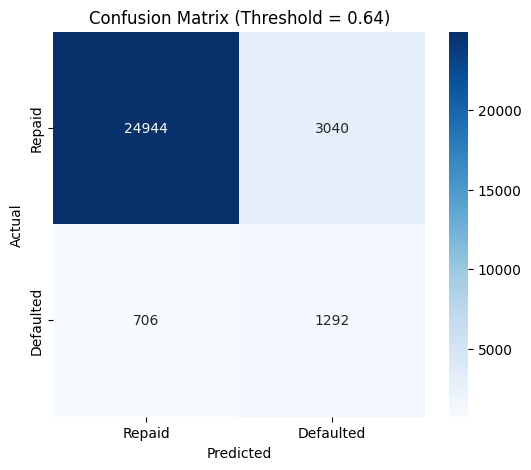

In [32]:
# Evaluation
y_probs = model_b.predict(dtest) 

# Target defaults
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
f_beta_scores = [fbeta_score(y_test, (y_probs > t).astype(int), beta=2) for t in thresholds]
best_thresh = thresholds[np.argmax(f_beta_scores)]

y_pred = (y_probs > best_thresh).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_pred, target_names=target_names)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)
roc_auc = roc_auc_score(y_test, y_probs)

print("Best threshold for F1:", best_thresh)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh:.2f})")
plt.show()
